IM2 李訓佑 b11705022

## 第一題 [Data Preprocessing]


Import processed data from homework for confirmation.

Now we now that `x_test` should be (15060, 102) and `x_train` is (30162, 102)

In [1]:
import pickle

dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
adult50kp['x_test'].shape, adult50kp['x_train'].shape

((15060, 102), (30162, 102))

First, import the orignal data and check its size

which is ((32561, 15), (16281, 15))


In [2]:
import pandas as pd
import numpy as np

rawdata = pd.read_csv("adult/adult.data", sep=',\s*', engine='python')
testdata = pd.read_csv("adult/adult.test", sep=',\s*', engine='python')

rawdata.shape, testdata.shape

((32561, 15), (16281, 15))

### Deal with missing data

Since only `workclass`, `occupation`, `native-country` has missing val, they are the 1,6,13 column.

So, I only need to check these three columns.

Use `rawdata.iloc[:, 1] == '?' `to locate all row that has '?' in col1, and get the union of these three columns.

Same for testdata.

Then, use `rawdata = rawdata[~mask1]` meaning that delete all rows in `mask1`

In [3]:
mask1 = (rawdata.iloc[:, 1] == '?') | ((rawdata.iloc[:, 6] == '?') | (rawdata.iloc[:, 13] == '?'))
rawdata = rawdata[~mask1]

mask2 = (testdata.iloc[:, 1] == '?') | ((testdata.iloc[:, 6] == '?') | (testdata.iloc[:, 13] == '?'))
testdata = testdata[~mask2]

rawdata.shape, testdata.shape

((30162, 15), (15060, 15))

We can see that the row size for train, test are right.

### Get y_train, y_test

First, set `replacement_map` indicating which val becomes what `replacement_map = {"<=50K": 0, ">50K": 1}`

Then, use `rawdata['income'].replace(replacement_map)` to get the new col.

Last, set `y_train` to `rawdata['income']`, `y_test` to `testdata['income']` and drop those 2 col.

In [4]:
from sklearn import preprocessing 

replacement_map = {"<=50K": 0, ">50K": 1}
rawdata['income'] = rawdata['income'].replace(replacement_map)
replacement_map = {"<=50K.": 0, ">50K.": 1}
testdata['income'] = testdata['income'].replace(replacement_map)

rawdata = rawdata.reset_index(drop=True)
testdata = testdata.reset_index(drop=True)

y_train = rawdata['income']
y_test = testdata['income']
rawdata.drop(columns=['income'], inplace=True)
testdata.drop(columns=['income'], inplace=True)

y_train, y_test

(0        0
 1        0
 2        0
 3        0
 4        0
         ..
 30157    0
 30158    1
 30159    0
 30160    0
 30161    1
 Name: income, Length: 30162, dtype: int64,
 0        0
 1        0
 2        1
 3        1
 4        0
         ..
 15055    0
 15056    0
 15057    0
 15058    0
 15059    1
 Name: income, Length: 15060, dtype: int64)

size right, wait for the last to confirm correctness

### Do 1-of-K encoding

Initialize `encoder = preprocessing.OneHotEncoder()`

Then, target col which needs to be turn into 1hot vector.

Since we already know `num_col = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']`are in int form, we only need to delete these val from the `rawdata.columns` and save it into `init_column_index`

Now, iterate through `init_column_index` to do 1-hot encoding for each col

In [5]:
# Initialize the OneHotEncoder
encoder = preprocessing.OneHotEncoder()

init_column_index = rawdata.columns
num_col = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
init_column_index = list(filter(lambda x: x not in num_col, init_column_index))

First, get the column and turn into np.array.

Then, put it into `encoder.fit_transform(tmp)`.

Get the new feature names through `encoder.get_feature_names_out([index])`.

Get the new processed array through `encoded.toarray()`.

Set the new dataframe with new feature name and values `pd.DataFrame(encoded, columns=feature_names, dtype=int)`.

Last, concat with `rawdata` and delete the original col.

In [6]:
for index in init_column_index:
    tmp = np.array(rawdata[[index]]).reshape(-1,1)
    encoded = encoder.fit_transform(tmp)
    feature_names = encoder.get_feature_names_out([index])
    encoded = encoded.toarray()
    encoded_df = pd.DataFrame(encoded, columns=feature_names, dtype=int)
    rawdata = pd.concat([rawdata, encoded_df], axis=1)
    rawdata.drop(index, axis=1, inplace=True)

The same with `testdata`

In [7]:
# Initialize the OneHotEncoder
init_column_index = testdata.columns
init_column_index = list(filter(lambda x: x not in num_col, init_column_index))

for index in init_column_index:
    tmp = np.array(testdata[[index]]).reshape(-1,1)
    encoded = encoder.fit_transform(tmp)
    feature_names = encoder.get_feature_names_out([index])
    encoded = encoded.toarray()
    encoded_df = pd.DataFrame(encoded, columns=feature_names, dtype=int)
    testdata = pd.concat([testdata, encoded_df], axis=1)
    testdata.drop(index, axis=1, inplace=True)

### Delete col which has less than 10 feature val.

Calculate each col's 1 through `rawdata.eq(1).sum()`

Then, target col which is less than 10.

Delete those col in `rawdata`

Since `testdata` doesn't have `'native-country_Holand-Netherlands'` we need to delete it from `columns_to_drop`

In [8]:
# Count the number of occurrences of 1 in each column
counts = rawdata.eq(1).sum()
columns_to_drop = counts[counts < 10].index
columns_to_drop = [x for x in columns_to_drop if x not in num_col]
rawdata.drop(columns=columns_to_drop, inplace=True)
columns_to_drop.remove('native-country_Holand-Netherlands')
testdata.drop(columns=columns_to_drop, inplace=True)


### Do standardization

Get mean and std_dev of each col with `preprocessing.StandardScaler().fit(rawdata[[column]])`, and do standardization to each col in `rawdata` and `testdata`

Meanwhile, sort the dataframe column into the order of adult50kp.

Lastly, put all of them into `adult50k`

In [9]:
for column in num_col:
    rawdatascalar = preprocessing.StandardScaler().fit(rawdata[[column]])
    rawdata[column] = rawdatascalar.transform(rawdata[[column]])
    testdata[column] = rawdatascalar.transform(testdata[[column]])

right_column = ['capital-loss', 'hours-per-week', 'capital-gain',
        'educational-num', 'age', 'fnlwgt', 'relationship_Husband',
        'relationship_Not-in-family', 'relationship_Other-relative',
        'relationship_Own-child', 'relationship_Unmarried',
        'relationship_Wife', 'race_Amer-Indian-Eskimo',
        'race_Asian-Pac-Islander', 'race_Black', 'race_Other',
        'race_White', 'gender_Female', 'gender_Male',
        'occupation_Adm-clerical', 'occupation_Craft-repair',
        'occupation_Exec-managerial', 'occupation_Farming-fishing',
        'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
        'occupation_Other-service', 'occupation_Priv-house-serv',
        'occupation_Prof-specialty', 'occupation_Protective-serv',
        'occupation_Sales', 'occupation_Tech-support',
        'occupation_Transport-moving', 'education_10th', 'education_11th',
        'education_12th', 'education_1st-4th', 'education_5th-6th',
        'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
        'education_Assoc-voc', 'education_Bachelors',
        'education_Doctorate', 'education_HS-grad', 'education_Masters',
        'education_Preschool', 'education_Prof-school',
        'education_Some-college', 'native-country_Cambodia',
        'native-country_Canada', 'native-country_China',
        'native-country_Columbia', 'native-country_Cuba',
        'native-country_Dominican-Republic', 'native-country_Ecuador',
        'native-country_El-Salvador', 'native-country_England',
        'native-country_France', 'native-country_Germany',
        'native-country_Greece', 'native-country_Guatemala',
        'native-country_Haiti', 'native-country_Honduras',
        'native-country_Hong', 'native-country_Hungary',
        'native-country_India', 'native-country_Iran',
        'native-country_Ireland', 'native-country_Italy',
        'native-country_Jamaica', 'native-country_Japan',
        'native-country_Laos', 'native-country_Mexico',
        'native-country_Nicaragua',
        'native-country_Outlying-US(Guam-USVI-etc)', 'native-country_Peru',
        'native-country_Philippines', 'native-country_Poland',
        'native-country_Portugal', 'native-country_Puerto-Rico',
        'native-country_Scotland', 'native-country_South',
        'native-country_Taiwan', 'native-country_Thailand',
        'native-country_Trinadad&Tobago', 'native-country_United-States',
        'native-country_Vietnam', 'native-country_Yugoslavia',
        'workclass_Federal-gov', 'workclass_Local-gov',
        'workclass_Private', 'workclass_Self-emp-inc',
        'workclass_Self-emp-not-inc', 'workclass_State-gov',
        'workclass_Without-pay', 'marital-status_Divorced',
        'marital-status_Married-AF-spouse',
        'marital-status_Married-civ-spouse',
        'marital-status_Married-spouse-absent',
        'marital-status_Never-married', 'marital-status_Separated',
        'marital-status_Widowed']

rawdata = rawdata[right_column]
testdata = testdata[right_column]

x_train = rawdata.values
x_test = testdata.values

adult50k = {'x_train':x_train,'y_train':y_train, 'x_test':x_test, 'y_test':y_test, 'columnname':rawdata.columns.values, 'num_col':num_col}

### Check

We can see that the data preprocessing is correct.

In [10]:
elems = ['x_train', 'x_test', 'y_train', 'y_test']

for aelem in elems:
    cnomatch = np.sum(adult50kp[aelem] != adult50k[aelem])
    if cnomatch == 0:
        print(aelem, "match!")
    else:
        print(aelem, "%d elements no match!" % cnomatch)


x_train match!
x_test match!
y_train match!
y_test match!


## 第二題 [ROC and AUC]

Get probability for each data
which is `ypredprob`


In [11]:
import pickle
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load dataset
dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
    
# train prediction model    
c = 0.3
lr2 = LogisticRegression(solver = 'lbfgs', C= c, max_iter = 1000)
lr2.fit(adult50kp['x_train'], adult50kp['y_train'])
# make prediction
ypred = lr2.predict(adult50kp['x_test'])
ypredprob = lr2.predict_proba(adult50kp['x_test'])
# compute accuracy
ncorrect = np.sum(adult50kp['y_test'] == ypred)
accuracy_sk = ncorrect / adult50kp['y_test'].shape[0]
print("Accuracy = %f" % accuracy_sk)    


Accuracy = 0.848406


### Calculate tpr & fpr

1. Concate prob array with true_y.

2. Sort according to positive probability.

        Get something like this : 

        [8.88178420e-16 1.00000000e+00 1.00000000e+00],

        [1.11022302e-15 1.00000000e+00 1.00000000e+00],
        
        [1.33226763e-15 1.00000000e+00 1.00000000e+00]...

 3. calculate tp, fp, tn, fn for different threshold

 4. save tpr and fpr for each loop

In [12]:
y_test_reshaped = adult50kp['y_test'].reshape(-1,1)
ypredprobwithrealy = np.concatenate((ypredprob, y_test_reshaped), axis=1)
sorted_indices = np.argsort(ypredprob[:, 0])
ypredprobwithrealy = ypredprobwithrealy[sorted_indices]
tpr = []
fpr = []

test_size =  adult50kp['y_test'].shape[0]

# run 45 sec
for t in range(1, adult50kp['y_test'].shape[0]):
    y_pred_tmp = np.zeros(test_size)
    y_pred_tmp[0:t] = 1
    y_true_tmp = ypredprobwithrealy[:, 2]
    TP = sum((y_true_tmp == 1) & (y_pred_tmp == 1))
    FP = sum((y_true_tmp == 0) & (y_pred_tmp == 1))
    TN = sum((y_true_tmp == 0) & (y_pred_tmp == 0))
    FN = sum((y_true_tmp == 1) & (y_pred_tmp == 0))
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    tpr.append(TPR)
    fpr.append(FPR)

### plot 

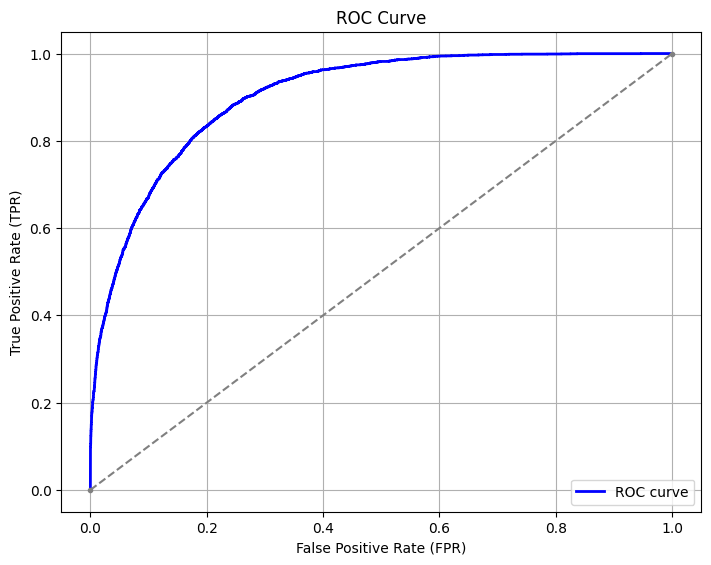

In [13]:
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', marker = '.')
plt.grid(True)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()


### Get AUC from the formula given

In [14]:
auc = 0
for x in range(len(tpr)-1):
    area = (1/2)*(tpr[x]+tpr[x+1])*(fpr[x+1]-fpr[x])
    auc += area
print(auc)

0.9034025504376968


From my own test using sklearn to reconfirm the answer, the curve looks almost the same, and AUC are both 0.9. We can see that the calculation is right

# 第三題 [Logistic Regression with L2 Regularization]


### Q3.1 Derive the gradient and hessian matrix for the new E(w)

All variable are the same as ppt, where $\phi$ is x

And $\Phi$ is defined differently, also from ppt

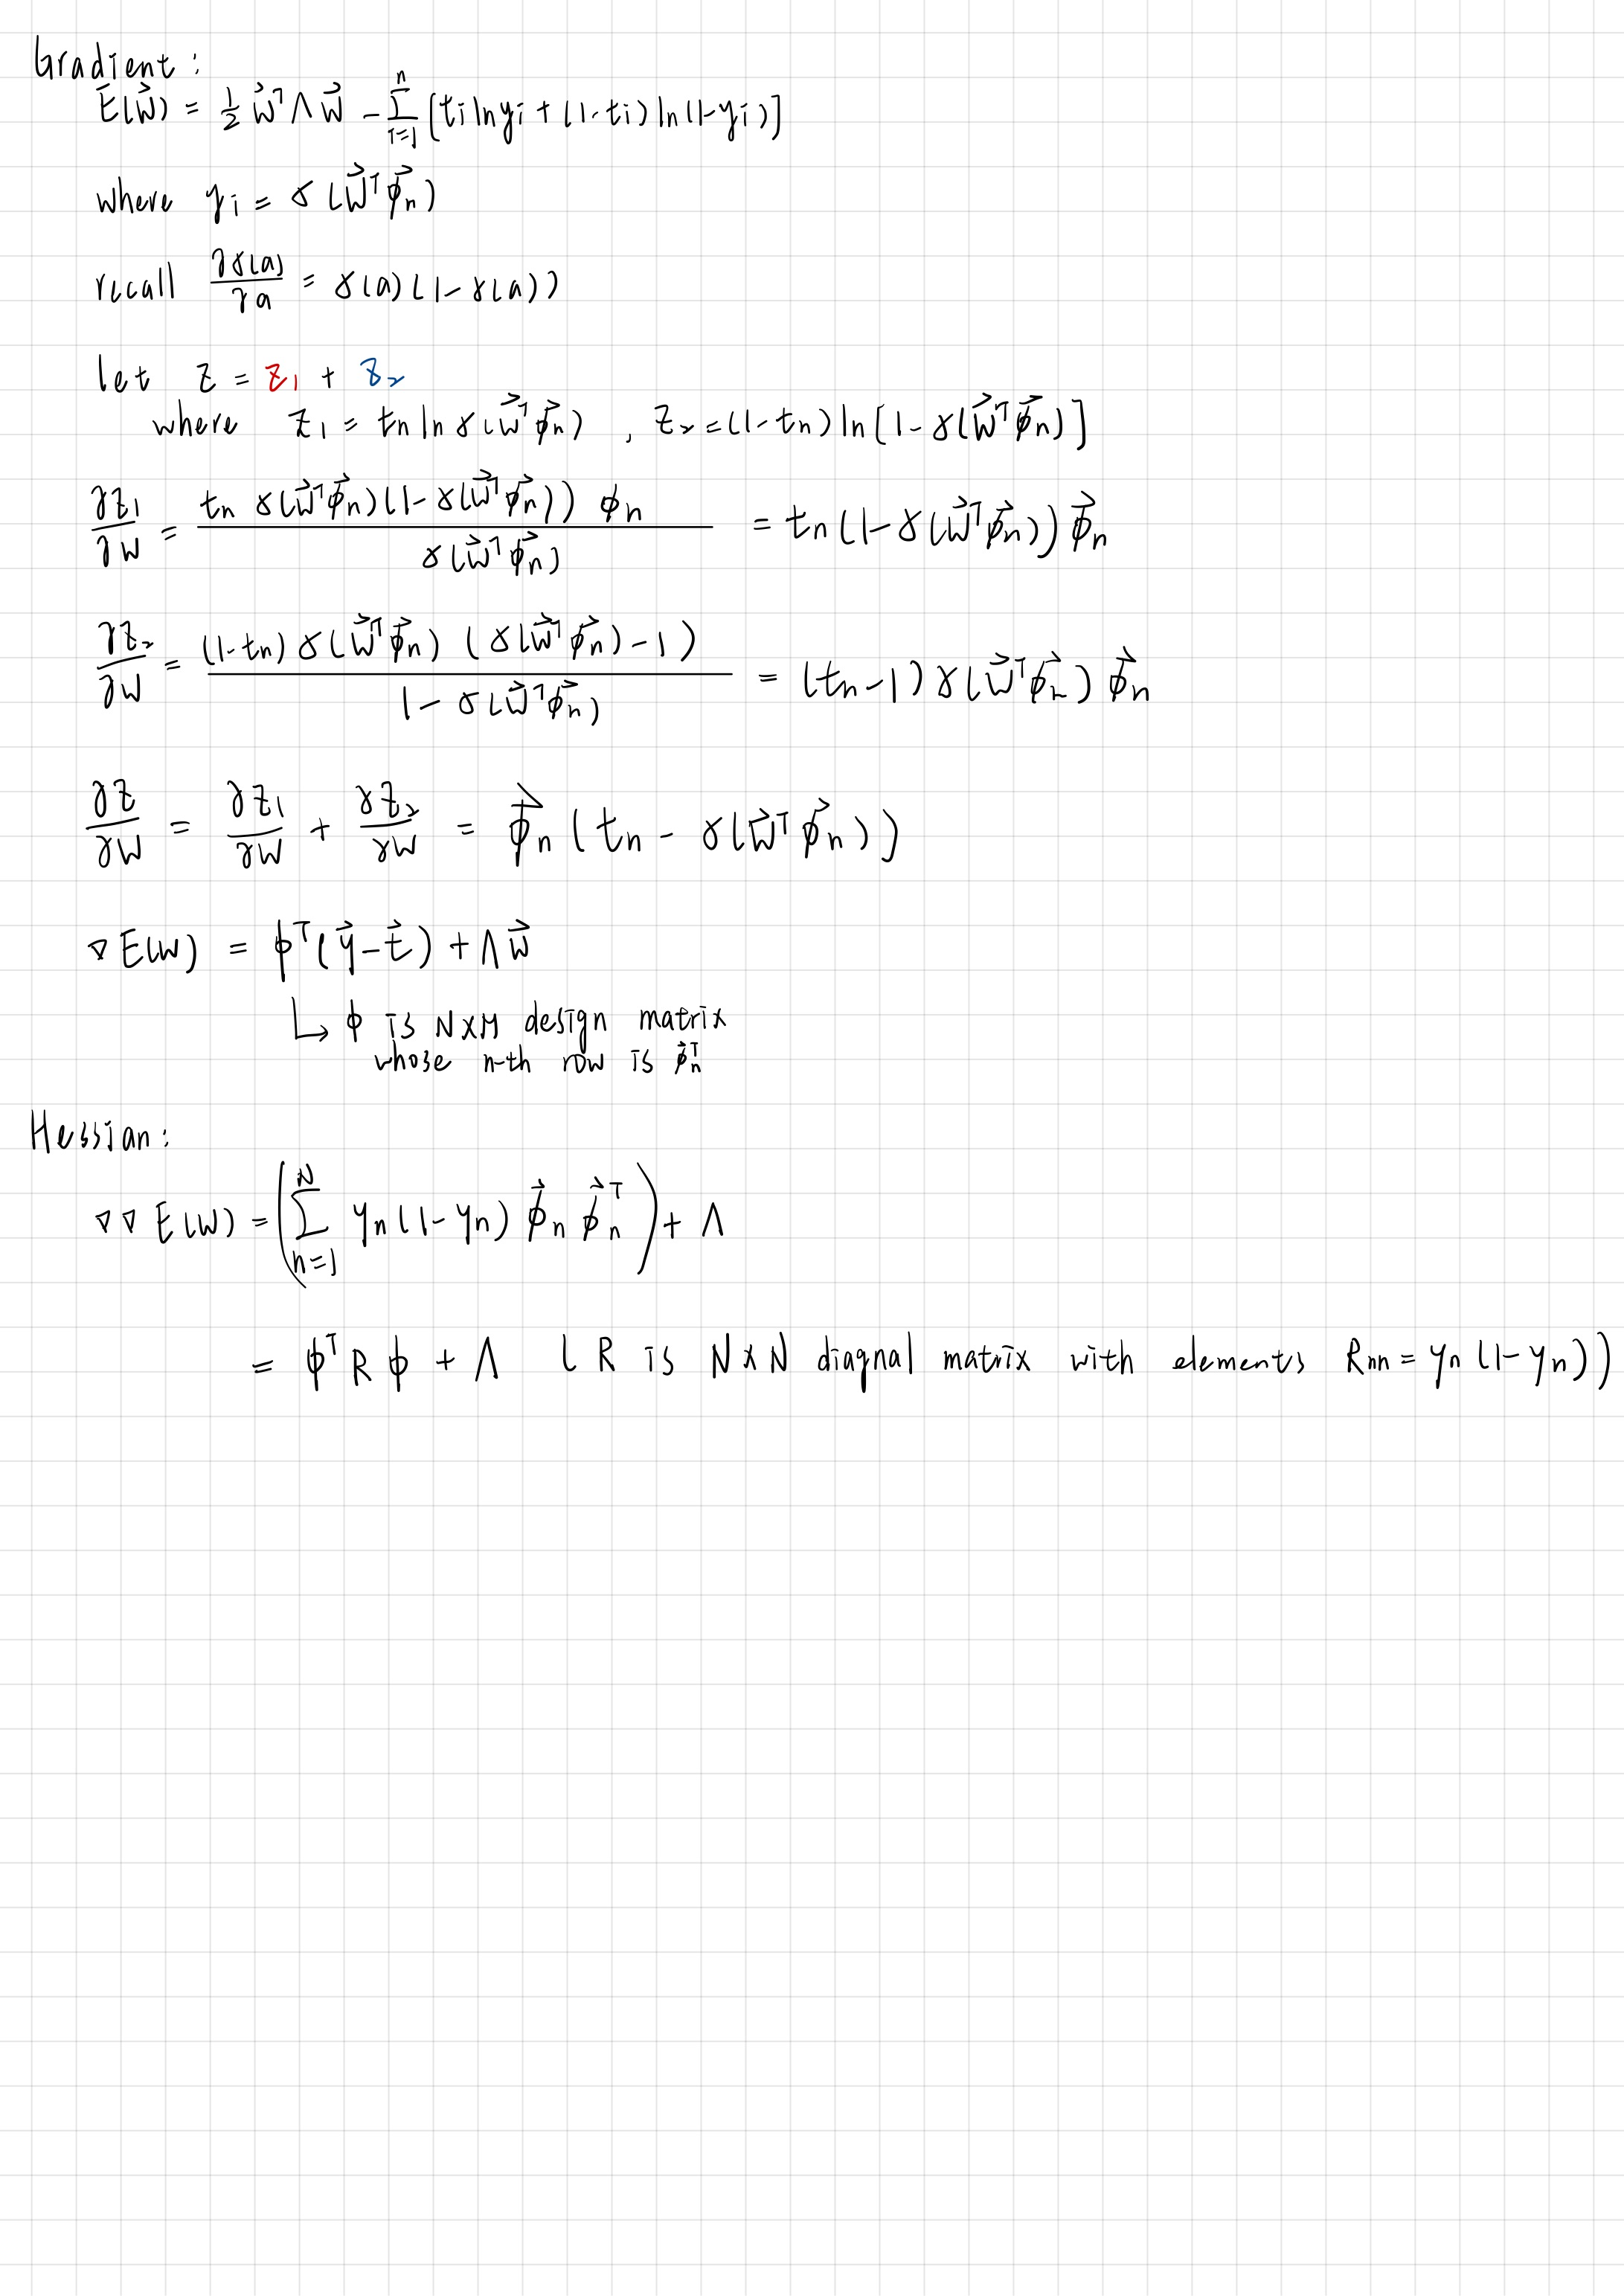

In [15]:
from IPython.display import Image

# Specify the path to your image file
image_path = "prove.jpg"  # Replace with the path to your image file

# Display the image in the Jupyter Notebook
Image(filename=image_path)

### Q3.2 Create mylogistic_l2 class

1. Check whether add_intercept, if true, add an column of 1 in front of x

2. Calculate the init w, which I use the closed-formm solution of ridge regression. $W = (X^TX + \lambda I)^{-1}X^Ty$

3. Start iteration

    1. Do Newton-Paphson optimization, which is in `self.newton`

        * $w^{(new)} = w^{(old)} - H^{-1} \nabla E$ -> the hessian matrix and gradient vector are proved above

    2. It automatically updates `self.w`, so we only need to put it into `W_list` to record history

    3. Get the val of error function through `self.error`

    4. Check whether smaller than the previous run

4. Output w, intercept, training loss, 


Moreover, I wrote a `accuracy()` function for later use of checking the accuray.

In [16]:
class mylogistic_l2():
    def __init__(self, reg_vec, max_iter = 100, tol = 1e-5, add_intercept = True):
        """reg_vec: the regularization coefficient vector
           max_iter: maximum number of iteration to run for the Newton method
           tol: tolerance for the objective function
           add_intercept: whether to add intercept (a column of ones) at last column of the feature matrix"""
        ### Add your code here
        self.reg_vec = reg_vec
        self.max_iter = max_iter
        self.tol = tol
        self.add_intercept = add_intercept

    def fit(self, x, y, verbal = False):
        y = y.reshape(-1,1)
        self.features = x.shape[1]
        self.samples = y.shape[0]
        
        # check whether add intercept
        if(self.add_intercept):
            intercept_col = np.ones((self.samples, 1))
            x = np.concatenate((intercept_col, x), axis=1)
            self.features += 1
        
        # get init w
        for_w_cal = np.linalg.inv(np.matmul(x.T, x) + (np.mean(self.reg_vec)*np.identity(self.features)))
        self.w = np.matmul(np.matmul(for_w_cal,x.T),y)
        E_prev = self.error(x,y)
        E_curr = 0

        # init e, w list
        E_list = [E_prev]
        W_list = [self.w]

        # start iteration
        for runcnt in range(self.max_iter):
            
            # do Newton-Raphson optimization
            self.newton(x,y)
            
            # update w
            W_list.append(self.w)

            # check whether below tol
            E_curr = self.error(x,y)
            diff = np.abs(E_curr - E_prev)
            E_list.append(E_curr)
            if diff < self.tol:
                print(
            f"""
Training Loss : {E_curr}
Interception : {self.w[0][0]}
Feature weights : 
{self.w[1:, 0].flatten()}
            """
                    )
                break
            E_prev = E_curr
            if(verbal):
                print(
            f"""
Training Loss : {E_curr}
Interception : {self.w[0][0]}
Feature weights : 
{self.w[1:, 0].flatten()}
            """
                    )
            
        return

    def predict(self, x):
        """doing prediction"""
        ### add your code here.
        if(self.add_intercept):
            intercept_col = np.ones((x.shape[0], 1))
            x = np.concatenate((intercept_col, x), axis=1)
        y_pred = self.sigmoid(x)
        return np.where(y_pred > 0.5, 1, 0)

    def sigmoid(self, x):
        y = np.matmul(x,self.w)
        sigmoid_values = 1 / (1 + np.exp(-y))
        return sigmoid_values
    
    def error(self, x, y):
        first = (1/2)*np.matmul(np.matmul(self.w.T,self.reg_vec),self.w)
        second = ( np.matmul(y.T,np.log(self.sigmoid(x))) )
        third = np.matmul( ((np.ones(y.shape[0]) - y.T)) ,(np.log(np.ones((y.shape[0],1)) - self.sigmoid(x))) ) 
        add = first - second - third
        return add[0][0]
    
    def newton(self, x, y):
        y_pred = self.sigmoid(x)
        gradient = np.matmul(self.reg_vec,self.w) + np.matmul(x.T,(y_pred - y))

        digonal_element = y_pred * (1-y_pred)
        R = np.diag(digonal_element.flatten())
        hessian = np.matmul(np.matmul(x.T,R),x) + self.reg_vec
        hessian_inv = np.linalg.inv(hessian)
        self.w = self.w - np.matmul(hessian_inv,gradient)



def accuracy(y_pred, y_true):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    TN = sum((y_true == 0) & (y_pred == 0))
    FN = sum((y_true == 1) & (y_pred == 0))
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    ACC = (TP+TN) / (TP+FP+TN+FN)
    print(f""" 
True Positive Rate : {TPR*100 :.3f}%
False Positive Rate : {FPR*100 :.3f}%
Accuracy : {ACC*100 :.3f}%
    """)
    return ACC



import training data

In [17]:
import pickle
import numpy as np

dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
X_train = adult50kp['x_train']
Y_train = adult50kp['y_train']
X_test = adult50kp['x_test']
Y_test = adult50kp['y_test']



####  Case 1: lambda = 1 for all coefficients

In [18]:
# case 1
lambda_vec1 = np.diag(np.ones(adult50kp['x_test'].shape[1]+1))
logic1 = mylogistic_l2(reg_vec = lambda_vec1, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic1.fit(X_train, Y_train)
ypred1 = logic1.predict(X_test)



Training Loss : 9775.247122461307
Interception : -1.3455248850675015
Feature weights : 
[ 2.58310749e-01  3.52951378e-01  2.33390152e+00  7.51145211e-01
  3.33524430e-01  7.92368680e-02 -2.59305992e-01 -3.31059192e-02
 -8.02092312e-01 -1.16328375e+00 -1.57480268e-01  1.06974336e+00
 -6.33846058e-01  1.16732409e-01 -2.31567381e-01 -5.17122207e-01
 -7.97216465e-02 -1.09949780e+00 -2.46027086e-01  6.19694928e-02
  1.26685884e-01  8.62656059e-01 -9.18352843e-01 -6.21226177e-01
 -2.00740224e-01 -7.51600981e-01 -1.61011588e+00  5.75820911e-01
  6.48995283e-01  3.53741434e-01  7.17218474e-01 -2.84494743e-02
 -9.54820746e-04 -1.96540899e-01 -1.46351640e-01  6.26946275e-01
  4.48207080e-01  2.45945819e-02  4.69223657e-02 -4.91067746e-01
 -2.03035424e-01 -1.63303680e-01 -1.76623501e-02 -1.11328323e-01
 -9.94618240e-02 -1.17391916e+00  1.80702678e-01 -6.92720004e-02
  9.76496905e-01  4.60988601e-01 -4.95440416e-01 -1.27203531e+00
  4.86772406e-01 -8.98963733e-01 -6.00542591e-02 -3.50848853e-01
 

Check accuracy

In [19]:
acc1 = accuracy(ypred1, adult50kp['y_test'])

 
True Positive Rate : 60.432%
False Positive Rate : 7.280%
Accuracy : 84.788%
    


#### Case 2: lambda = 1 for all but the intercept, no regularization for intercept term.

In [20]:
lambda_vec2 = np.diag(np.ones(adult50kp['x_test'].shape[1]+1))
lambda_vec2[0][0] = 0
logic2 = mylogistic_l2(reg_vec = lambda_vec2, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic2.fit(X_train, Y_train)
ypred2 = logic2.predict(X_test)


Training Loss : 9773.111183558507
Interception : -3.175085772940549
Feature weights : 
[ 0.25833063  0.35307341  2.33348255  0.7378757   0.33385106  0.07926886
 -0.04219572  0.1998764  -0.58360968 -0.93671312  0.07548468  1.28715744
 -0.37140327  0.39422898  0.04305748 -0.26147348  0.19559029 -0.42695771
  0.42695771  0.16424528  0.22840772  0.96472553 -0.81743779 -0.52074423
 -0.09910239 -0.64944042 -1.55235098  0.6786798   0.75066429  0.45541098
  0.81857112  0.07308911  0.0728464  -0.11752644 -0.06282948  0.67242506
  0.5040869   0.08799091  0.11435013 -0.38483984 -0.10196309 -0.05145374
  0.10741777 -0.01997934  0.01717544 -1.16567808  0.30082277  0.02715464
  1.00831207  0.50210397 -0.45756662 -1.24002555  0.52780939 -0.86832688
 -0.02771494 -0.31412701  0.47343435  0.62981111  0.62405658 -0.5867506
 -0.0296708   0.12414401 -0.14376238  0.02434194  0.0621604  -0.24843986
  0.19459429  0.52620501  0.93165615  0.18707696  0.37950109 -0.28749402
 -0.31137357 -0.33290534 -0.65117786 

check accuracy

In [21]:
acc2 = accuracy(ypred2, adult50kp['y_test'])

 
True Positive Rate : 60.378%
False Positive Rate : 7.280%
Accuracy : 84.774%
    


#### Case 3: lambda = 1 for numerical-valued features, lambda = 0.5 for binary-valued features, no regularization for intercept term.

In [22]:
lambda_vec3 = np.diag(np.ones(adult50kp['x_test'].shape[1]+1))
lambda_vec3[0][0] = 0
for i in range(7, lambda_vec3.shape[0]):
    lambda_vec3[i][i] = 0.5
logic3 = mylogistic_l2(reg_vec = lambda_vec3, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic3.fit(X_train, Y_train)
ypred3 = logic3.predict(X_test)


Training Loss : 9764.222592337468
Interception : -3.362690328884574
Feature weights : 
[ 0.25851661  0.3533387   2.33562764  0.7825921   0.33439916  0.07940036
 -0.08347988  0.23309134 -0.59278098 -0.9224849   0.11139573  1.25425869
 -0.38299462  0.41291781  0.04136013 -0.26411462  0.19283128 -0.42890321
  0.42890321  0.23635122  0.30021361  1.03810521 -0.75216086 -0.4534137
 -0.02691157 -0.5825269  -2.00075382  0.75127891  0.82696617  0.52830705
  0.89488994  0.14510375  0.18253094 -0.02583999  0.00991404  0.89862004
  0.68517002  0.23294385  0.24519931 -0.38363083 -0.08029608 -0.06493444
  0.0453608   0.03743376 -0.01295908 -2.09374319  0.25763304  0.06659781
  1.18748312  0.55059265 -0.47576613 -1.45842154  0.5822242  -1.0627833
 -0.00957211 -0.31704572  0.52485137  0.73044517  0.67457228 -0.63624179
 -0.00967268  0.17339113 -0.2364757   0.0375474   0.10120874 -0.24679341
  0.23800627  0.64228457  1.00567032  0.23258941  0.42267607 -0.35336167
 -0.29178766 -0.38125401 -0.96291964 -

check accuracy

In [23]:
acc3 = accuracy(ypred3, adult50kp['y_test'])

 
True Positive Rate : 60.405%
False Positive Rate : 7.298%
Accuracy : 84.768%
    


We can see that the accuracy doesn't vary much, case 1 is the highest, but only won by 0.01 percent.

### Q3.3 split the training data into subtraining (90%) and tuning (10%) to search for the best hyperparameters.



Devide the data, and set target grids

In [24]:
X_subtrain = X_train[0:int(len(X_train)*0.9)]
X_tuning = X_train[int(len(X_train)*0.9):]
Y_subtrain = Y_train[0:int(len(X_train)*0.9)]
Y_tuning = Y_train[int(len(X_train)*0.9):]
grids = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100]


#### Conduct grid search with the constraint that $a_1 = a_2$. 

basicly iterate through `grids` and do the same thing as above

In [25]:
acc1 = []
# 4m30sec
for grid in grids:
    print("Grid : ",grid)
    lambda_vec_grid = np.diag(np.ones(X_subtrain.shape[1]+1)*grid)
    lambda_vec_grid[0][0] = 0
    logic_grid = mylogistic_l2(reg_vec = lambda_vec_grid, max_iter = 1000, tol = 1e-5, add_intercept = True)
    logic_grid.fit(X_subtrain, Y_subtrain)
    ypred_grid = logic_grid.predict(X_tuning)
    acctmp = accuracy(ypred_grid, Y_tuning)
    acc1.append(acctmp)
    print('-------------------')

Grid :  0.01

Training Loss : 8749.80168216729
Interception : -4.867485394428733
Feature weights : 
[ 0.24968195  0.3531762   2.32570894  1.1732743   0.3393035   0.07826813
 -0.18181321  0.32127373 -0.75211349 -0.86997464  0.22660416  1.25602345
 -0.29144563  0.44083896  0.06244911 -0.4125294   0.20068696 -0.45111521
  0.45111521  0.95446576  1.03376704  1.73648829 -0.05570834  0.27452742
  0.67650849  0.08649613 -2.95202623  1.48015826  1.54663911  1.24433633
  1.68655397  0.90160657  1.07777705  0.63416835  0.61036315  2.31553605
  1.81865509  1.42668939  1.14155319 -0.55146101 -0.0597559  -0.32911115
 -0.66181138  0.36716909 -0.41909965 -7.29203854 -0.30299798  0.22436427
  1.3524331   0.7212734  -0.52479319 -1.60999422  0.79621285 -1.30924557
 -1.06289642 -0.19593446  0.71071258  1.10573668  0.99450395 -0.54770176
 -1.75742629  0.37974377 -0.71061692  0.57465861  0.474886   -0.16158592
  0.51718359  1.03744046  1.28022988  0.76888404  0.49766022  0.07582221
 -0.03530877 -0.32043933

Record the best value $a_1^*$ and $a_2^*$.

In [26]:
max_a = max(acc1)
max_index = acc1.index(max_a)
a1star = grids[max_index]
a1star

5

In this case $a_1^* = 5$

#### Fix $a_1 = a_1^*$, and search $a_2$ for the best value, call the result the new $a_2^*$. 

we know $a1=5$ so iterate through `grids` and change val of $a2$

In [27]:
acc2 = []

for grid in grids:
    print("Grid : ",grid)
    lambda_vec_grid = np.diag(np.ones(X_subtrain.shape[1]+1)*grid)
    lambda_vec_grid[0][0] = 0
    for i in range(7, lambda_vec_grid.shape[0]):
        lambda_vec_grid[i][i] = a1star
    logic_grid = mylogistic_l2(reg_vec = lambda_vec_grid, max_iter = 1000, tol = 1e-5, add_intercept = True)
    logic_grid.fit(X_subtrain, Y_subtrain)
    ypred_grid = logic_grid.predict(X_test)
    acctmp = accuracy(ypred_grid, Y_test)
    acc2.append(acctmp)
    print('------------')

Grid :  0.01

Training Loss : 8817.976478071823
Interception : -2.9219606422254976
Feature weights : 
[ 2.47697020e-01  3.52385253e-01  2.27228647e+00  7.18895375e-01
  3.38453054e-01  7.69590012e-02  8.81903081e-02  9.75125729e-02
 -6.62943741e-01 -9.35218216e-01 -1.98222623e-02  1.43228134e+00
 -2.21989717e-01  2.84541841e-01  6.72011237e-02 -3.39039033e-01
  2.09285786e-01 -4.25418554e-01  4.25418554e-01  5.38787380e-02
  1.29917290e-01  8.18078803e-01 -9.02640756e-01 -5.77985232e-01
 -2.21104569e-01 -7.66113089e-01 -6.51831769e-01  5.66416942e-01
  5.96514650e-01  3.28638456e-01  7.37674186e-01 -1.69219579e-03
  9.28746475e-02 -1.43929676e-01 -1.17996663e-02  2.68867591e-01
  1.99859092e-01  8.28534055e-02 -2.59628788e-02 -4.07733491e-01
 -1.24720285e-01 -3.80351893e-02  1.31525382e-01 -6.34005721e-02
  3.75173340e-02 -2.68874481e-01  2.93767449e-01 -2.28086617e-02
  3.72791172e-01  3.06298021e-01 -3.70333490e-01 -5.63323004e-01
  3.28281922e-01 -3.81230139e-01 -2.68104252e-01 -2.1

Because using y_tuning, all accuracy are the same, so i use y_test this time

In [28]:
max_a = max(acc2)
max_index = acc2.index(max_a)
a2star = grids[max_index]
a2star

50

$a^*_2 = 50$

In [29]:
acc3 = []

for grid in grids:
    print("Grid : ",grid)
    lambda_vec_grid = np.diag(np.ones(X_subtrain.shape[1]+1)*a2star)
    lambda_vec_grid[0][0] = 0
    for i in range(7, lambda_vec_grid.shape[0]):
        lambda_vec_grid[i][i] = grid
    logic_grid = mylogistic_l2(reg_vec = lambda_vec_grid, max_iter = 1000, tol = 1e-5, add_intercept = True)
    logic_grid.fit(X_subtrain, Y_subtrain)
    ypred_grid = logic_grid.predict(X_test)
    acctmp = accuracy(ypred_grid, Y_test)
    acc3.append(acctmp)
    print('------------------')

Grid :  0.01

Training Loss : 8860.990318817721
Interception : -5.440103044583633
Feature weights : 
[ 0.23828893  0.34148313  1.80150768  0.01062876  0.33005486  0.07665408
 -0.17618646  0.33382392 -0.75034686 -0.86544062  0.22556697  1.23258303
 -0.26243026  0.43088073  0.06221164 -0.42168097  0.19101886 -0.44206507
  0.44206507  0.95865529  1.03575794  1.73295393 -0.02667196  0.27417353
  0.68194462  0.08556435 -2.2442368   1.48101926  1.5349761   1.24504137
  1.67680017  0.90253405 -0.25100548 -0.21096062  0.20190953 -0.82430721
 -0.86106819 -0.78760807 -0.64214302  0.85940625  0.89788475  1.53081991
  2.55833941  0.41515342  1.90023302 -7.96622476  2.45635407  0.72321699
  1.33080658  0.70308082 -0.49679529 -1.59798173  0.7918979  -1.34423435
 -0.99273716 -0.16955242  0.7261855   1.10492971  0.98439009 -0.46057234
 -1.55794536  0.33496611 -0.71542208  0.53695559  0.50070639 -0.1599775
  0.49254237  1.03883144  1.27844881  0.72294376  0.48912899  0.0597809
 -0.04581147 -0.35033475 

In [30]:
max_a = max(acc3)
max_index = acc3.index(max_a)
a1star = grids[max_index]
a1star

20

$a^*_1 = 20$

### Q3.4

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


model = LogisticRegression(C = a1star, max_iter=100000)
model.fit(X_train, Y_train)
y_pred_sklearn = model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_sklearn)
print(accuracy)


0.847675962815405


The accuracy is 84.768%

Mine is 84.768%

They are identical.